In [1]:
import sys
import os

import torch
import random
import warnings
import time

import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
import torchvision
import torchvision.transforms.functional as TF
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchaudio.transforms import Convolve
from scipy.ndimage import gaussian_filter1d
from cca_zoo.linear import rCCA
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")

# Import MI files
from utils import *
from models import *
from estimators import *
from trainers import *

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['figure.dpi'] = 100

# Set global font sizes for better readability
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.titlesize': 18})
plt.rcParams.update({'axes.labelsize': 16})
plt.rcParams.update({'xtick.labelsize': 15})
plt.rcParams.update({'ytick.labelsize': 15})
plt.rcParams.update({'legend.fontsize': 15})

# Directories
main_dir = os.getcwd()
model_cache_dir = os.path.join(main_dir, '..', 'model_cache')

# Set default type now
default_dtype = torch.float32
torch.set_default_dtype(default_dtype)

# To-do list:
- [] Remove chunked inference, it has issues. Swap to CPU based inference, only run post-hoc
- [] Image based method

- [/] Parallel training with shared memory, fixed to have the right number of processes

- [] Try ISI encoding instead (as in https://pmc.ncbi.nlm.nih.gov/articles/PMC9870156/)


In [2]:
# Check if CUDA or MPS is running
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = "CPU"

print(f'Device: {device}')

Device: cuda


In [3]:
# To be fully centered kernel should have odd number of elements!
# Requires torch tensors as both inputs
def convolve_spike_train(X, kernel):
    kernel_len = len(kernel)
    offset = (kernel_len - 1) // 2
    all_inds = torch.nonzero(X, as_tuple=True)
    # Create output array as zero-padded input 
    X = torch.zeros(X.shape[0], X.shape[1] + 2 * offset, dtype=kernel.dtype)
    # Can't think of a way to do this vectorized b/c I'm lazy
    for i in range(X.shape[0]):
        inds = all_inds[1][all_inds[0] == i] + offset
        for j in inds:
            low_ind = j - offset
            high_ind = j - offset + kernel_len
            X[i,low_ind:high_ind] += kernel
    # Remove padding
    X = X[:, offset:-offset]
    return X

Neurons (X): torch.Size([32, 1865558])
Muscles (Y): torch.Size([10, 1865558])
Neuron Labels: ['87', '29', '1', '78', '12', '20', '2', '6', '41', '11', '13', '65', '89', '15', '75', '42', '33', '28', '14', '39', '21', '7', '96', '68', '8', '88', '93', '26', '10', '0', '30', '3']
Muscle Labels: ['rsa', 'rdvm', 'lba', 'ldvm', 'rdlm', 'lsa', 'rax', 'lax', 'rba', 'ldlm']


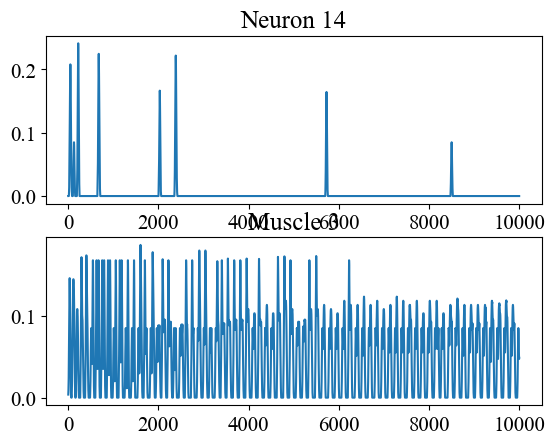

In [4]:
# Read the data and have some binning
data_dir = os.path.join(os.getcwd(), '..', 'data_for_python')
X, Y, x_labels, y_labels = process_spike_data(os.path.join(data_dir, '2025-03-21'), 0.001)
# Convert to torch tensors, "Convolve" with gaussian to get continuous form
X, Y = torch.tensor(X, dtype=default_dtype), torch.tensor(Y, dtype=default_dtype)
kernel = torch.signal.windows.gaussian(51, std=10, dtype=torch.float32).type(default_dtype)
X, Y = convolve_spike_train(X, kernel), convolve_spike_train(Y, kernel)
# Clip low values to zero so batch detection works okay
X[X < 0.01] = 0.
Y[Y < 0.01] = 0.
# Rescale all values to same scale
maxval = torch.maximum(X.max(), Y.max())
X /= maxval
Y /= maxval

print(f"Neurons (X): {X.shape}")
print(f"Muscles (Y): {Y.shape}") 
print("Neuron Labels:", x_labels)
print("Muscle Labels:", y_labels)

# Plot sample of activity
pl = 10000
useneuron, usemuscle = np.random.choice(X.shape[0]), np.random.choice(Y.shape[0])
idx = torch.nonzero(Y[usemuscle,:] > 0)[0][0]
fig, ax = plt.subplots(2, 1)
ax[0].plot(X[useneuron,idx:idx+pl])
ax[1].plot(Y[usemuscle,idx:idx+pl])
ax[0].set_title(f'Neuron {useneuron}')
ax[1].set_title(f'Muscle {usemuscle}')
fig.show()

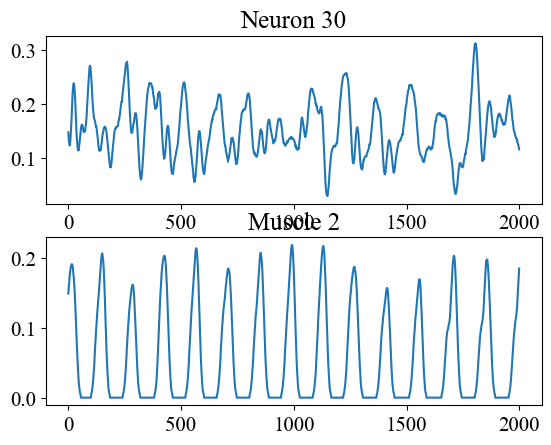

In [5]:
pl = 2000
useneuron, usemuscle = np.random.choice(X.shape[0]), np.random.choice(Y.shape[0])
idx = torch.nonzero(Y[usemuscle,:] > 0)[0][0]
fig, ax = plt.subplots(2, 1)
idx = idx + 4000
ax[0].plot(X[useneuron,idx:idx+pl])
ax[1].plot(Y[usemuscle,idx:idx+pl])
ax[0].set_title(f'Neuron {useneuron}')
ax[1].set_title(f'Muscle {usemuscle}')
fig.show()

In [6]:
params = {
    # Optimizer parameters (for training)
    'epochs': 200,
    'batch_size': 128,
    'learning_rate': 5e-3,
    'n_trials': 3,
    'patience': 50,
    'min_delta': 0.001,
    'eps': 1e-8, # Use 1e-4 if dtypes are float16, 1e-8 for float32 works okay
    # Critic parameters for DSIB or DVSIB (for the estimator), except embed_dim, which changes with training
    'Nx': X.shape[0],
    'Ny': Y.shape[0],
    # 'Nx': 1,
    # 'Ny': 1,
    'layers': 3,
    'hidden_dim': 512,
    'activation': 'softplus', #'leaky_relu',
    'beta': 512,
    'max_dz': 12, # max value for embed_dim that we search for
    'estimator': 'infonce', # Estimator: infonce or smile_5. See estimators.py for all options
    'mode': 'sep', # Almost always we'll use separable
    'chunked_inference': False, 
    'chunk_size': 1000,
}

# Make dataset
# dataset = BatchedDataset(X, Y, params['batch_size'])
# full_dataset = create_data_split(dataset, train_fraction=0.95, device=device)

In [7]:
torch.cuda.empty_cache()
this_params = {**params, 'embed_dim': 10, 'batch_size': 512}
dataset = BatchedDataset(X, Y, this_params['batch_size'])
full_dataset = create_data_split(dataset, train_fraction=0.9, eval_fraction=0.2, device=device)
mis, mis_test = train_model(DSIB, full_dataset, this_params)
# misv, misv_test = train_model(DVSIB, full_dataset, this_params)

Train time = 2.73891019821167


OutOfMemoryError: CUDA out of memory. Tried to allocate 22.56 GiB. GPU 0 has a total capacity of 6.00 GiB of which 4.73 GiB is free. Of the allocated memory 66.39 MiB is allocated by PyTorch, and 157.61 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

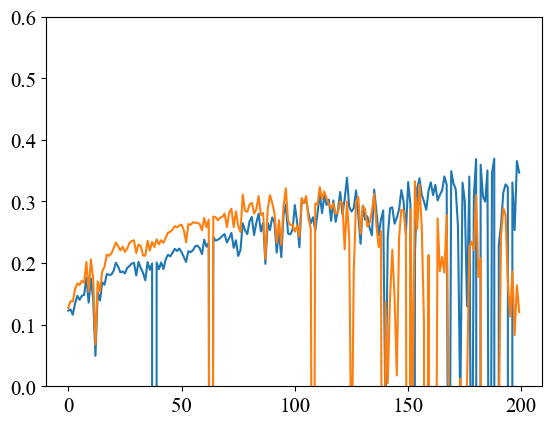

NameError: name 'misv' is not defined

<Figure size 640x480 with 0 Axes>

In [7]:
plt.figure()
plt.plot(mis)
plt.plot(mis_test)
plt.gca().set_ylim(0, 0.6)
plt.show()
plt.figure()
plt.plot(misv)
plt.plot(misv_test)
plt.show()

In [ ]:
from tqdm.auto import tqdm
# Empty arrays and do the run, will take forever
mi = {}
mi_test = {}
models = {}
ids = {}
batch_size_range = np.array([64, 128, 256, 512])

for bs in batch_size_range:
    dataset = BatchedDataset(X, Y, bs)
    for dz in tqdm(range(5, params['max_dz']+1)):
        print(f'Starting dz = {dz}')
        for j in range(params['n_trials']):
            this_params = {**params, 'embed_dim': dz, 'batch_size': bs}
            print(f'batch size = {bs}, dz = {dz}, trial = {j+1}')
            torch.cuda.empty_cache()
            full_dataset = create_data_split(dataset, train_fraction=0.9, eval_fraction=0.1, device=device)
            # mis, mis_test = train_model(DSIB, full_dataset, this_params)
            mis_test, train_id = train_model_no_eval(DSIB, full_dataset, this_params, model_cache_dir)
            mod = retrieve_best_model(model_cache_dir, mis_test, train_id=train_id, burn_in=1)
            # Store results
            # mi[f"trial_{j}_dz_{dz}_bs_{bs}"] = mis
            key = f"trial_{j}_dz_{dz}_bs_{bs}"
            mi_test[key] = mis_test
            models[key] = mod
            ids[key] = train_id


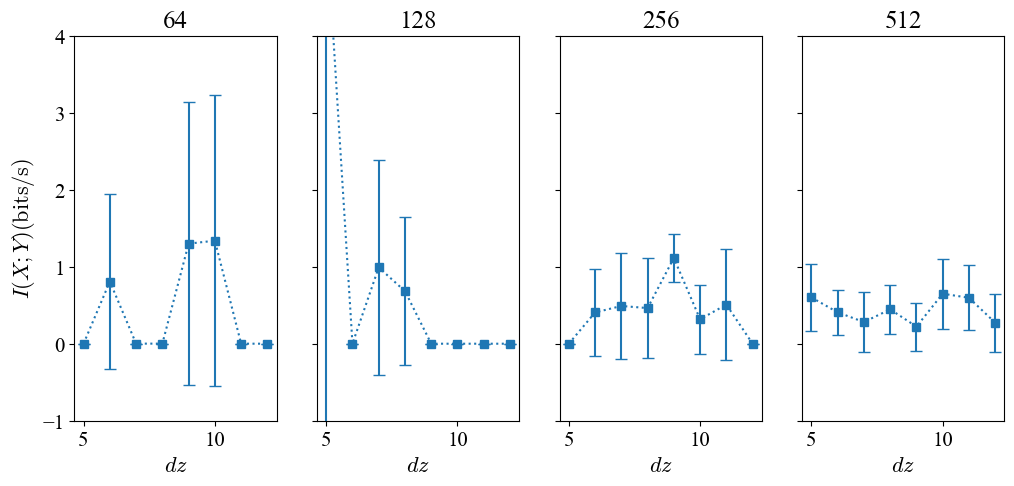

In [88]:
# Define sigma, a small number is usually the best choice
sigma=1 # (or 2 at most)

fig, ax = plt.subplots(1, len(batch_size_range), figsize=(12,5), sharey=True)
for i,bs in enumerate(batch_size_range):    
    dz_means = []
    dz_stds = []
    for dz in range(5, params['max_dz']+1):
        mi_trials = []
        for j in range(params['n_trials']):
            key = f"trial_{j}_dz_{dz}_bs_{bs}"
            # Convert Nan to zeros and smooth
            # train = gaussian_filter1d(np.nan_to_num(mi[key]), sigma=sigma)
            test = gaussian_filter1d(np.nan_to_num(mi_test[key]), sigma=sigma) / bs * np.log2(np.e) * 1000
            # Pick the epoch with highest test value and get corresponding train
            best = np.argmax(test)
            mi_trials.append(test[best])
        dz_means.append(np.mean(np.array(mi_trials)).flatten())
        dz_stds.append(np.std(np.array(mi_trials)).flatten())
    b = ax[i].errorbar(
        range(5, params['max_dz']+1), np.array(dz_means).flatten(), 
        yerr=np.array(dz_stds).flatten(), 
        fmt='s:', capsize=4)

    # Set title and scales
    ax[i].set_title(str(bs))
    ax[i].set_xlabel(r'$dz$')
    if i == 0:
        ax[i].set_ylabel(r'$I(X;Y) \text{(bits/s)}$');
    ax[i].set_ylim(-1, 4)


trial_0_dz_10_bs_64


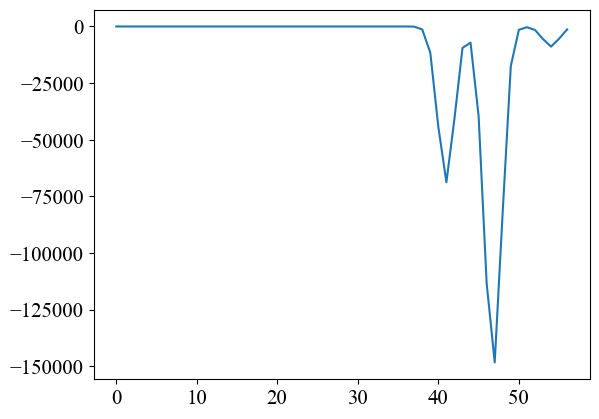

In [72]:
key = random.choice(list(mi_test.keys()))
sigma = 1
# plt.plot(gaussian_filter1d(np.nan_to_num(mi[key]), sigma=sigma))
plt.plot(gaussian_filter1d(np.nan_to_num(mi_test[key]) * np.log2(np.e), sigma=sigma))
# plt.gca().set_ylim(0)
print(key)

In [82]:
import pickle

with open(os.path.join(main_dir, 'mi_test_2025-04-27.pkl'), 'wb') as f:
    pickle.dump(mi_test, f)
with open(os.path.join(main_dir, 'ids_2025-04-27.pkl'), 'wb') as f:
    pickle.dump(ids, f)


In [91]:
ids

{'trial_0_dz_5_bs_64': 'DSIB_dz-5_bs-64_8fd6f693-0e8c-4050-80f0-71743727faf4',
 'trial_1_dz_5_bs_64': 'DSIB_dz-5_bs-64_53c1ac4c-c23f-4fb7-b0de-03609854555d',
 'trial_2_dz_5_bs_64': 'DSIB_dz-5_bs-64_980c7b88-ae7e-45c8-8654-43988f324259',
 'trial_0_dz_6_bs_64': 'DSIB_dz-6_bs-64_f5780180-bfd3-435e-b811-ea7695d4a1b5',
 'trial_1_dz_6_bs_64': 'DSIB_dz-6_bs-64_bd177624-0f1d-47e3-9b66-3efe1affcb26',
 'trial_2_dz_6_bs_64': 'DSIB_dz-6_bs-64_e444d9e9-1f41-4509-8b87-95f2bcb4c6ba',
 'trial_0_dz_7_bs_64': 'DSIB_dz-7_bs-64_9dc5f773-c58a-41b1-8d58-f154bc18fe83',
 'trial_1_dz_7_bs_64': 'DSIB_dz-7_bs-64_136f4efa-0772-4a42-b8d1-163fcca65eda',
 'trial_2_dz_7_bs_64': 'DSIB_dz-7_bs-64_aa666a3e-dd74-47c8-9e75-a2260fe347af',
 'trial_0_dz_8_bs_64': 'DSIB_dz-8_bs-64_aaf1e6a7-8d80-4aba-bfe0-8fc840cb522f',
 'trial_1_dz_8_bs_64': 'DSIB_dz-8_bs-64_ef96a2d7-2bcc-45d7-b9ec-20ad29bfc0a7',
 'trial_2_dz_8_bs_64': 'DSIB_dz-8_bs-64_b53fd0ff-c038-4b42-b96d-2a9a32ea69e8',
 'trial_0_dz_9_bs_64': 'DSIB_dz-9_bs-64_6ce81eb9-0f7

In [ ]:
with open(os.path.join(main_dir, 'mi_test_2025-04-27.pkl'), 'rb') as f:
    bob = pickle.load(f)
with open(os.path.join(main_dir, 'ids_2025-04-27.pkl'), 'rb') as f:
    bob = pickle.load(f)

Okay, so running on the whole dataset takes a long time. 


Scheme for a given moth:
- X embedding dimension sizes
- Y repeats at each embedding dim size
- Z batch sizes